### ヒートマップの一例

In [37]:
using IntervalArithmetic
using LaTeXStrings
using Plots

In [38]:
include("./heatmap/index.jl")
include("./method1/index.jl")
include("./method2/index.jl")
include("./method3/index.jl")
include("./method4/index.jl")
include("./intervalPCM/index.jl")
include("./twofoldInterval/index.jl")
include("./twofoldIntervalPCM/index.jl")

print()

In [39]:
function revisedMat(
        A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}}
        ) where {T <: Real}
    Ã₁⁻, Ã₁⁺ = generateRevisedMatrix(A₁)
    Ã₂⁻, Ã₂⁺ = generateRevisedMatrix(A₂)
    return ((Ã₁⁻, Ã₁⁺), (Ã₂⁻, Ã₂⁺))
end

revisedMat (generic function with 1 method)

In [40]:
function method1(A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}}) where {T <: Real}
    A = intervalPCM2TwofoldIntervalPCM(A₁, A₂)
    result = solveLP_m1(A)
    Â = updatePCM_m1(A, result)
    return Â
end

method1 (generic function with 1 method)

In [41]:
function  method2(A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}}) where {T <: Real}
    εᶿ = solveIndividualCancellingLP_m2([A₁, A₂])
    result = solveApproximationLP_m2([A₁, A₂], εᶿ)
    A = importance2TwofoldIntervalPCM_m2(result)
    return A
end

method2 (generic function with 1 method)

In [42]:
function method3(A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}}) where {T <: Real}
    approximationResults = solveApproximationLP_m3.([A₁, A₂])
    tBoundaries = calculateTBoundaries_m3.(approximationResults)
    result = solveConcatLP_m3(approximationResults, tBoundaries)
    Â = generatePCM_m3(result)
    return Â
end

method3 (generic function with 1 method)

In [43]:
function method4(A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}}) where {T <: Real}
    results = solveApproximationLP_m4.([A₁, A₂])
    A = generateTwofoldIntervalMatrix_m4(results)
    result = solveCancellingLP_m4(A)
    Â = updatePCM_m4(A, result)
    return Â
end

method4 (generic function with 1 method)

In [44]:
methodDescriptions = [
    "与えられた PCM を結合して整合化",
    "整合化しながら重要度の上・下近似を求めて PCM にする",
    "DM ごとに求めた重要度の上・下近似を整合化しながら結合して PCM にする",
    "DM ごとに求めた重要度の上・下近似から二重区間 PCM を作って結合して整合化する"
]

function plotAll(A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}}) where {T <: Real}
    display(L"A_1 = %$(intervalMatrixLaTeXString(A₁))")
    display(L"A_2 = %$(intervalMatrixLaTeXString(A₂))")

    m = 2 # DM の数

    revisedMatrices = revisedMat(A₁, A₂)
    resultMatrices = twofoldIntervalMatrix2intervalMatrices.(
        [method1(A₁, A₂), method2(A₁, A₂), method3(A₁, A₂), method4(A₁, A₂)])
    
    for k = eachindex(resultMatrices), l = 1:m
        Âₖ⁻, Âₖ⁺ = resultMatrices[k]
        Ãₗ⁻, Ãₗ⁺ = revisedMatrices[l]

        title⁻ = L"\frac{\left| \tilde{A}_{%$(l)ij}^- \cap \hat{A}_{%$(k)ij}^- \right|}{\left| \tilde{A}_{%$(l)ij}^- \cup \hat{A}_{%$(k)ij}^- \right|}"
        title⁺ = L"\frac{\left| \tilde{A}_{%$(l)ij}^+ \cap \hat{A}_{%$(k)ij}^+ \right|}{\left| \tilde{A}_{%$(l)ij}^+ \cup \hat{A}_{%$(k)ij}^+ \right|}"

        heatmap⁻ = plotConincidenceIndices(Ãₗ⁻, Âₖ⁻, title⁻)
        heatmap⁺ = plotConincidenceIndices(Ãₗ⁺, Âₖ⁺, title⁺)

        p = plot([heatmap⁻, heatmap⁺]..., layout=(1, 2), size=(500, 250), legend=false)
        display("$(methodDescriptions[k]), DM: $(l)")
        display(p)
    end
end

plotAll (generic function with 1 method)

L"$A_1 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 2.7, 3.2 \right] & \left[ 0.303, 0.333 \right] \\ \left[ 0.312, 0.37 \right] & \left[ 1.0, 1.0 \right] & \left[ 0.1, 0.103 \right] \\ \left[ 3.0, 3.3 \right] & \left[ 9.7, 10.0 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

L"$A_2 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 2.2, 2.8 \right] & \left[ 0.25, 0.357 \right] \\ \left[ 0.357, 0.455 \right] & \left[ 1.0, 1.0 \right] & \left[ 0.102, 0.103 \right] \\ \left[ 2.8, 4.0 \right] & \left[ 9.7, 9.8 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

"与えられた PCM を結合して整合化, DM: 1"

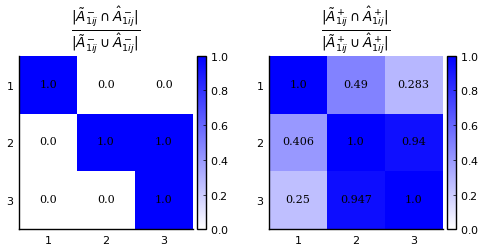

"与えられた PCM を結合して整合化, DM: 2"

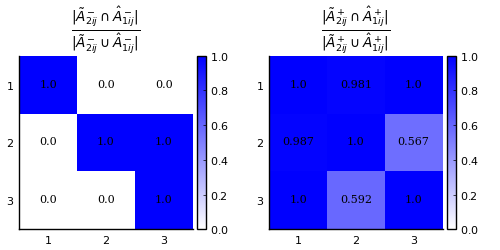

"整合化しながら重要度の上・下近似を求めて PCM にする, DM: 1"

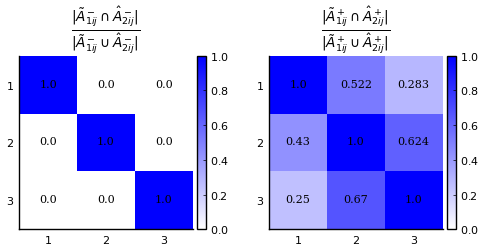

"整合化しながら重要度の上・下近似を求めて PCM にする, DM: 2"

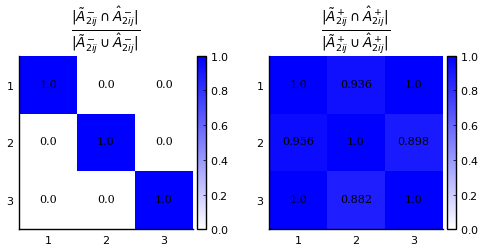

"DM ごとに求めた重要度の上・下近似を整合化しながら結合して PCM にする, DM: 1"

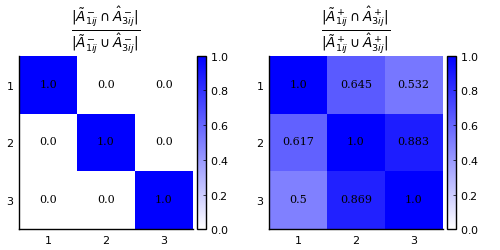

"DM ごとに求めた重要度の上・下近似を整合化しながら結合して PCM にする, DM: 2"

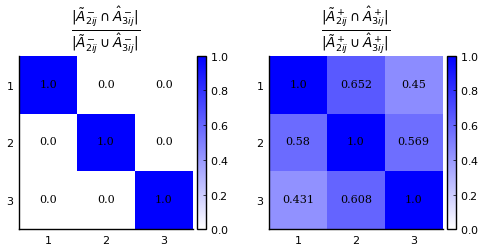

"DM ごとに求めた重要度の上・下近似から二重区間 PCM を作って結合して整合化する, DM: 1"

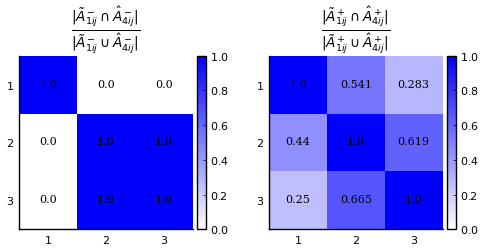

"DM ごとに求めた重要度の上・下近似から二重区間 PCM を作って結合して整合化する, DM: 2"

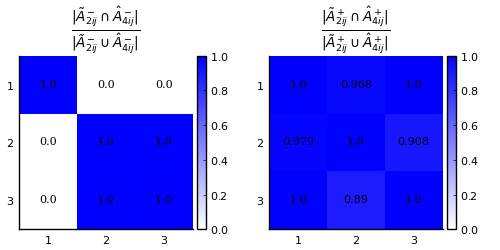

In [45]:
A₁ = [
    1..1 2.7..3.2 (1/3.3)..(1/3)
    (1/3.2)..(1/2.7) 1..1 (1/10)..(1/9.7)
    3..3.3 9.7..10 1..1
]
A₂ = [
    1..1 2.2..2.8 (1/4)..(1/2.8)
    (1/2.8)..(1/2.2) 1..1 (1/9.8)..(1/9.7)
    2.8..4 9.7..9.8 1..1
]

plotAll(A₁, A₂)